![image.png](attachment:b0e30ea8-3e0b-4792-9231-cdcaa22b4be7.png)
## House Prices - Advanced Regression Techniques with EDA

Data of Start: 24.Sep.2021

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home

* random forest, gradient boosting (XGBoost with Parameter Tuning.. LASSO)

### Table of Contents
1. [Handling Null Values (Train set)](#nullvalue)

2. [Handling Null Values (Test set)](#nulltest)

3. [EDA](#EDA)

   3.1. [Quantitative Variables](#EDAquant)
    
   3.2. [Categorical Variables](#EDAcateg)
    

4. [Feature Engineering](#feature)

   4.1. [Dealing with Outliers with Lasso](#lasso)
    
   4.2. [Imbalanced features (binning)](#binning)
   
   4.3. [Skewed data (log transformation)](#skewed)
   
   4.4. [Encoding](#encoding)

5. [Modelling](#modelling)

   5.1. [Parameter Tuning](#tuning)
    
   5.2. [Stacking](#stacking)
    




In [3]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [6]:
# Import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Drop Id Column
df_train = df_train.drop(columns = 'Id', axis = 1)
df_test = df_test.drop(columns = 'Id', axis = 1)

# Distinguish attributes between quantitative and categorical attributes
categorical = df_train.select_dtypes(include = ['object', 'category']).columns

quantitative = df_train.select_dtypes(include = ['int64', 'float64'])
quant_order = quantitative.nunique().sort_values(ascending = False).index.tolist()
quantitative = quantitative[quant_order].columns

There are 1460 instances with 81 attributes in training and test data. It consists of 36 quantitative attributes, 43 categorical attributes, Id and SalePrice which is an attribute we have to predict.

- Quantitative: 1stFlrSF, 2ndFlrSF, 3SsnPorch, BedroomAbvGr, BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, EnclosedPorch, Fireplaces, FullBath, GarageArea, GarageCars, GarageYrBlt, GrLivArea, HalfBath, KitchenAbvGr, LotArea, LotFrontage, LowQualFinSF, MSSubClass, MasVnrArea, MiscVal, MoSold, OpenPorchSF, OverallCond, OverallQual, PoolArea, ScreenPorch, TotRmsAbvGrd, TotalBsmtSF, WoodDeckSF, YearBuilt, YearRemodAdd, YrSold

- Categorical: Alley, BldgType, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual, CentralAir, Condition1, Condition2, Electrical, ExterCond, ExterQual, Exterior1st, Exterior2nd, Fence, FireplaceQu, Foundation, Functional, GarageCond, GarageFinish, GarageQual, GarageType, Heating, HeatingQC, HouseStyle, KitchenQual, LandContour, LandSlope, LotConfig, LotShape, MSZoning, MasVnrType, MiscFeature, Neighborhood, PavedDrive, PoolQC, RoofMatl, RoofStyle, SaleCondition, SaleType, Street, Utilities,

### 1. Handling Null Values (Train set) <a name="nullvalue"></a>

Let's check whether there is null value in each attribute.

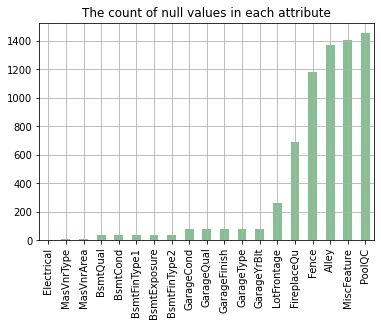

In [7]:
missing = df_train.isnull().sum()
ax = missing[missing > 0].sort_values().plot.bar(color='#86bf91', grid = True)
ax.set_title('The count of null values in each attribute')
plt.show()

There are 19 variables having missing data in the train set. In this case, missing data means the house does not have the subject. For example, missing data (null data) in Fence means that property does not have fence. Also, when GarageCond is Null, it perhaps does not have garage so the condition is not recorded. In this kind of column, null value is actually another category, named 'Not present'

Instead of dropping data for these columns for those variables having missing values, we will make them clean for future engineering process. 

In [8]:
# Not present category
null_category = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                 'FireplaceQu', 'GarageCond', 'GarageQual', 
                 'GarageFinish', 'GarageType', 'BsmtCond', 
                 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 
                 'BsmtFinType2']

# Fill null values with 'None' for Not present category.
for column in null_category:
    df_train[column].fillna('None', inplace = True)
    
    
# After imputing `None` for the columns, we will handle other variables having null values.
null_columns = df_train.isnull().sum() > 0 # Columns having null values
df_train.loc[:, null_columns].isna().sum() # The count of null values in quantitative variables

LotFrontage    259
MasVnrType       8
MasVnrArea       8
Electrical       1
GarageYrBlt     81
dtype: int64

#### 1.1. LotFrontage & MasVnrArea (continous variables)

For missing data imputation for LotFrontage and MasVnrArea which are continous variables, KNN imputer to predict the missing values. Before we implement KNN, we have to scale our data because KNN is a distance-based algorithm. Since we have not handled outliers yet, we will use RobustScaler to reduce the effects of outliers. 


> *KNNImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html*

> *RobustScaler: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html*


First, we will use continous variables to predict continous variables and categorical variables for categorical variable prediction. Then, use robust scaler, impute missing values with KNN imputer, and do inverse transform to get normalised data back to the original data at last. 

1. Use Scaler 
2. KNN Imputer
2. Use inverse_transform()

In [9]:
# Impute LotFrontage & MasVnrArea (continous variables)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Continuous variables for scaler
cont_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
             '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
             'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']

scaler = RobustScaler()
scaler_transform = pd.DataFrame(scaler.fit_transform(df_train[cont_vars].copy()), columns = ["col" + str(i) for i in range(0, 15)])

knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
knn_imp_results = knn_imputer.fit_transform(scaler_transform)
knn_imp_results = pd.DataFrame(scaler.inverse_transform(knn_imp_results), columns = ['col' + str(i) for i in range(0, 15)])


# Replace LotFrontage & MasVnrArea with imputed values from knn imputer above
df_train['LotFrontage'] = knn_imp_results['col0']
df_train['MasVnrArea'] = knn_imp_results['col2'].astype('float64')

#### 1.2. MasVnrType & Electrical (categorical)

For the rest of variables which are MasVnrType, Electrical, since they have few number of missing values, mode will be imputed to handle missing values. The mode is the value that appears most frequently in a data set.

In [ ]:
# MasVnrType & Electrical (categorical)
df_train['MasVnrType'] = df_train['MasVnrType'].fillna(df_train['MasVnrType'].mode()[0])
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

#### 1.3. GarageYrBlt

It is indentified that GararaYrBlt has 81 missing values in its column. As we consider GarageYrBlt a categorical variable, we will use only categorical variables for Label Encoder to use KNNImputer. Why we use Label Encoder over One-Hot Encoding is that the number of categories is quite large as one-hot encoding can lead to high memory consumption.

In [ ]:
# Get a dataframe with variables of object and category type.
categorical_train = df_train.drop(cont_vars, axis = 1) # Drop continous variables
categorical_train = categorical_train.drop('SalePrice', axis = 1) # Drop SalePrice
categorical_variables = categorical_train.select_dtypes(include = ['object', 'category']).columns # Get only variables of object and category type

# Use LabelEncoder
from sklearn.preprocessing import LabelEncoder
for column in categorical_variables:
    categorical_train[column] = LabelEncoder().fit_transform(categorical_train[column])
    
# KNN Imputer
knnimputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
knn_categ_results = knnimputer.fit_transform(categorical_train)
knn_categ_results = pd.DataFrame(knn_categ_results, columns = ["col" + str(i) for i in range(0, 64)])

df_train['GarageYrBlt'] = knn_categ_results['col48']
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('int64')

### 2. Handling Null Values (Test set)<a name="nulltest"></a>

We will apply same method of missing value imputation for test set. The test set must use identical scaling to the training set.

In [ ]:
# Fill null values with 'None' for Not present category.
for column in null_category:
    df_test[column].fillna('None', inplace = True)
    
    
# After imputing `None` for the columns, we will handle other variables having null values.
null_columns = df_test.isnull().sum() > 0 # Columns having null values
df_test.loc[:, null_columns].isna().sum() # The count of null values in quantitative variables

In [ ]:
missing_test = df_test.isnull().sum()
ax = missing_test[missing_test > 0].sort_values().plot.bar(color='#86bf91', grid = True)
ax.set_title('The count of null values in each attribute')
plt.show()

#### 2.1. LotFrontage & MasVnrArea (continous variables)

In [ ]:
# Impute LotFrontage & MasVnrArea (continous variables)
scaler_transform_test = pd.DataFrame(scaler.fit_transform(df_test[cont_vars].copy()), columns = ["col" + str(i) for i in range(0, 15)])

knn_imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
knn_imp_results_test = knn_imputer.fit_transform(scaler_transform)
knn_imp_results_test = pd.DataFrame(scaler.inverse_transform(knn_imp_results_test), columns = ['col' + str(i) for i in range(0, 15)])


# Replace LotFrontage & MasVnrArea with imputed values from knn imputer above
df_test['LotFrontage'] = knn_imp_results_test['col0']
df_test['MasVnrArea'] = knn_imp_results_test['col2'].astype('float64')

#### 2.2. Other variables with few missing values

We will impute the mean for quantitative variables, and impute the mode for categorical variables.

In [ ]:
# Get column names having null values
null_columns = [i for i in df_test.columns if (df_test[i].isnull().any()) & (i != 'GarageYrBlt')]

for column in null_columns:
    if df_test[column].dtypes == 'object':
        df_test[column] = df_test[column].fillna(df_test[column].mode()[0])
    
    elif df_test[column].dtypes == 'float64':
        df_test[column] = df_test[column].fillna(df_test[column].mean())

#### 2.3. GarageYrBlt

In [ ]:
# Get a dataframe with variables of object and category type.
categorical_test = df_test.drop(cont_vars, axis = 1) # Drop continous variables
categorical_variables = categorical_test.select_dtypes(include = ['object', 'category']).columns # Get only variables of object and category type

# Use LabelEncoder
for column in categorical_variables:
    categorical_test[column] = LabelEncoder().fit_transform(categorical_test[column])
    
# KNN Imputer
knnimputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
knn_categ_results_test = knnimputer.fit_transform(categorical_test)
knn_categ_results_test = pd.DataFrame(knn_categ_results_test, columns = ["col" + str(i) for i in range(0, 64)])

df_test['GarageYrBlt'] = knn_categ_results_test['col48']
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].astype('int64')

### 3. EDA <a name ="EDA"></a>
#### 3.1. Quantitative Variables <a name = "EDAquant"></a>
#### • Distribution



In Machine learning or Deep Learning, some of the models such as Linear Regression, Logistic Regression assume that features are normally distributed. Also, If the features provided to them during modeling are normally distributed, the models can perform much better.


To check the distribution, we will use histogram of SalePrice and its logarithm.

In [ ]:
ax1 = df_train.SalePrice.hist(color='#86bf91')
ax1.set_title('SalePrice Histogram')
plt.show()

In [ ]:
ax2 = df_train.SalePrice.hist(color='#86bf91', log = True)
ax2.set_title('SalePrice Histogram in Log')
plt.show()

As these two histograms show right-skewness, it is obvious that SalePrice does not follow normal distribution. Therfore,  transformation for normalisation should be conducted in the further process before performing regression.

To check other attributes, Shapiro-Wilk Test will be conducted for all quantitative attributes. The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution. The `shapiro()` SciPy function will calculate the Shapiro-Wilk on a given dataset. The function returns both the W-statistic calculated by the test and the p-value.

Firstly, We will replace null values with 0. Then, use `shapiro()` to check p-value whether the p-value is under 0.01 and see whether there is any quantitiative attribute following normal distribution.

In [ ]:
normality_test = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01 # Conduct shapiro test on each attribute
df_quant = pd.DataFrame(df_train[quantitative])
normal = df_quant.apply(normality_test)
normal.any()

It turns out that the p-value of all quantitiative attirbutes is less than 0.01, which means that none of quantitative attributes follows normal distribution and attributes need transformation.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

f = sns.FacetGrid(df_quant.melt(), col='variable', col_wrap=2, sharex=False, sharey=False)
f.map(sns.distplot, 'value', color = 'y')

Some independent variables such as LotFrontage,GrLivArea and TotalBsmtSF look like good candidates for log transformation. Logarithm naturally reduces the dynamic range of a variable so the differences are preserved while the scale is not that dramatically skewed. Regression transformation will smooth out some irregularities which could be important for feature construction.

#### • Scatter Plot

In [ ]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 7, 
                          'xtick.labelsize': 5, 'ytick.labelsize': 5}): 

    fig, ax = plt.subplots(5, 5, figsize = (8.5, 10), sharey = True)

    for idx, (column, axes) in list(enumerate(zip(quantitative[0:22], ax.flatten()))):
    
        sns.scatterplot(ax = axes, x = df_train[column], 
                        y = np.log(df_train['SalePrice']), 
                        hue =  np.log(df_train['SalePrice']), 
                        palette = 'viridis', alpha = 0.7, s = 8)
    
        axes.legend([], [], frameon = False)
    
    else:
    
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    plt.tight_layout()
    plt.show()

In [ ]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 7, 
                          'xtick.labelsize': 5, 'ytick.labelsize': 5}): 

    fig, ax = plt.subplots(5, 5, figsize = (8.5, 10), sharey = True)

    for idx, (column, axes) in list(enumerate(zip(quantitative[22:], ax.flatten()))):
    
        sns.scatterplot(ax = axes, x = df_train[column], 
                        y = np.log(df_train['SalePrice']), 
                        hue =  np.log(df_train['SalePrice']), 
                        palette = 'viridis', alpha = 0.7, s = 8)
    
        axes.legend([], [], frameon = False)
    
    else:
    
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    plt.tight_layout()
    plt.show()

The scatter plots show the presence of imbalance in each attribute and identify which variables are continous and discrete. Based on this, we will keep balanced variables and unbalanced variables separately.

In [ ]:
cont_balanced = ['LotArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 
                 'GarageArea', '2ndFlrSF', 'MasVnrArea', 'WoodDeckSF', 'LotFrontage',  
                 'OpenPorchSF', 'BsmtFinSF2',  'EnclosedPorch','ScreenPorch',  'GrLivArea']

cont_unbalanced = ['LowQualFinSF', 'MiscVal', '3SsnPorch' , 'PoolArea']

#### • Heat Map

In [ ]:
quant_price_corr = df_train[quantitative].corr()
plt.figure(figsize = (15,10))
sns.heatmap(quant_price_corr.corr(), fmt='.2g',cmap= 'PiYG')

It is observed that some attributes such as LotFrontage, LotArea, OverallQual have positive correlation with SalePrice. 

Especially, GarageCars, GarageArea, OverallQual, YearBuilt have significantly positive correlation with SalePrice.

#### 3.2. Categorical Variables <a name = "EDAcateg"></a>

In [ ]:
# Get categorical columns
categorical = df_train.drop(cont_balanced, axis = 1) # drop balanced continous
categorical = categorical.drop('SalePrice', axis = 1) # drop SalePrice column
categorical = categorical.drop(cont_unbalanced, axis = 1).columns.to_list() # drop unbalanced continous

# Check cardinality 
df_train[categorical].nunique().sort_values(ascending = False) # show the number of unique elements in each object

As we check the number of unique elements in each object, we will define high cardinality as the number of unique value >= 50 in this project. High cardinality means high dimensionality in matrix and it often results in overfitting. Therefore, visualisation for observations and the method of feature engineering should be different depending on the degree of cardinality,.

#### • High Cardinality Features

In [ ]:
df_train[categorical].loc[:, df_train.nunique() > 50].nunique().sort_values(ascending = False)

In [ ]:
high_cardinality_df = df_train[categorical].loc[:, df_train.nunique() > 50] # Get a df with only high cardinality feature
high_cardinality_df.info() # check data type

As data type of high cardinality features is int64, we will change the data type into category.

In [ ]:
for column in high_cardinality_df.columns:
    high_cardinality_df[column] = high_cardinality_df[column].astype('category')

In [ ]:
# Create visualisation
with plt.rc_context(rc = {'figure.dpi': 450, 'axes.labelsize': 5, 
                          'xtick.labelsize': 4, 'ytick.labelsize': 4}): 

    fig, ax = plt.subplots(1, 3, figsize = (6, 7.5))

    for idx, (column, axes) in list(enumerate(zip(high_cardinality_df.columns, ax.flatten()))): 
    
        sns.stripplot(ax = axes, x = np.log(df_train['SalePrice']), 
                      y = high_cardinality_df[column], 
                      palette = 'viridis', alpha = 0.95, size = 1.5)

        sns.boxplot(ax = axes, x = np.log(df_train['SalePrice']), 
                    y = high_cardinality_df[column],
                    showmeans = True, meanline = True, zorder = 10,
                    meanprops = {'color': 'r', 'linestyle': '-', 'lw': 0.8},
                    medianprops = {'visible': False},
                    whiskerprops = {'visible': False},
                    showfliers = False, showbox = False, showcaps = False)
        
        sns.pointplot(ax = axes, x = np.log(df_train['SalePrice']), 
                      y = high_cardinality_df[column],
                      ci = None, color = 'r', scale = 0.15)
    
    else: 
    
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]
    
    plt.tight_layout()
    plt.show()

GarageYrBlt, YearRemodAdd, YearBuilt seem to have positivie relationship with SalePrice. As the number comes to the recent, the sale price is increasing in the overall trend. 

#### • Manageable Cardinality Features
For the rest of categorical features possesing manageable cardinality under 50, we will use scatterplot to visualise.

In [ ]:
# Get column names with only manageable cardinality features
normal_cardinality = df_train[categorical].loc[:, df_train.nunique() <= 50].columns.to_list() 

In [ ]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 7, 
                          'xtick.labelsize': 5, 'ytick.labelsize': 5}): 

    fig, ax = plt.subplots(3, 4, figsize = (8.5, 10), sharey = True)

    for idx, (column, axes) in list(enumerate(zip(normal_cardinality[:12], ax.flatten()))):
    
        sns.scatterplot(ax = axes, x = df_train[column], 
                        y = np.log(df_train['SalePrice']), 
                        hue =  np.log(df_train['SalePrice']), 
                        palette = 'viridis', alpha = 0.7, s = 8)
    
        axes.legend([], [], frameon = False)
        
        
        if df_train[column].nunique() > 5: 
            
            plt.setp(axes.get_xticklabels(), rotation = 90)
    
    else:
    
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    plt.tight_layout()
    plt.show()

In [ ]:
with plt.rc_context(rc = {'figure.dpi': 500, 'axes.labelsize': 7, 
                          'xtick.labelsize': 5, 'ytick.labelsize': 5}): 

    fig, ax = plt.subplots(3, 4, figsize = (8.5, 10), sharey = True)

    for idx, (column, axes) in list(enumerate(zip(normal_cardinality[:12], ax.flatten()))):
    
        sns.scatterplot(ax = axes, x = df_train[column], 
                        y = np.log(df_train['SalePrice']), 
                        hue =  np.log(df_train['SalePrice']), 
                        palette = 'viridis', alpha = 0.7, s = 8)
    
        
        
        if df_train[column].nunique() > 5: 
            
            plt.setp(axes.get_xticklabels(), rotation = 90)
    
    else:
    
        [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]

    plt.tight_layout()
    plt.show()

### 4. Feature Engineering <a name = "feature"></a>

#### 4.1. Dealing with Outliers with Lasso <a name = "lasso"></a>
Residuals is one of measures to help us identify outliers. To find a residual, you must take the predicted value and subtract it from the measured value. Lasso which is robust to outliers is used to get predicted value. As it needs caustion to consider removing observations from the data and all data should be encoded properly, indexes of rows to drop were obtained after encoding.



In [ ]:
# Run after encoding to identify the indexes of rows to drop
from sklearn import linear_model
# Training a model
# Lasso_outliers = linear_model.Lasso(alpha = 0.0005)
# Lasso_fit = Lasso_outliers.fit(train_X, train_Y)

# Getting outliers
# residuals = (Lasso_fit.predict(train_X) - df_train['SalePrice'])**2
# print(residuals.plot()) # visualise residuals
# print(residuals.sort_values(ascending = False).head(10))

In [ ]:
rows_to_drop = [691, 1182, 1169, 898, 803, 1046, 440]
df_train = df_train.drop(rows_to_drop, axis = 0).reset_index(drop = True)

#### 4.2. Imbalanced features (binning) <a name = "binning"></a>
To handle with imbalanced features, we will use binning for imbalanced features such as LowQualFinSF, MiscVal, 3SsnPorch and PoolArea. Binning will convert continous ones to categorical ones (None or Present). Binning of continuous variable introduces non-linearity and tends to improve the performance of the model.

In [ ]:
# Binning (none or present)
for column in cont_unbalanced:
    # Train
    df_train.loc[(df_train[column] == 0), column] = 'None'
    df_train.loc[(df_train[column] != 0) & (df_train[column] != 'None'), column] = 'Present'
    
    # Test
    df_test.loc[(df_test[column] == 0), column] = 'None'
    df_test.loc[(df_test[column] != 0) & (df_test[column] != 'None'), column] = 'Present'

#### 4.3. Skewed data (log transformation) <a name = "skewed"></a>
For skewed data, log transformation will help to reduce skewness. If the original data follows a log-normal distribution or approximately so, then the log-transformed data follows a normal or near normal distribution. In this case, the log-transformation does remove or reduce skewness. From our observations, we suspected balanced variables which follow normal distribution with skewness. Use log tranformation on them. 

In [ ]:
# Log transformationo for balance continous variables
df_train[cont_balanced] = np.log(df_train[cont_balanced] + 1) # +1 for avoiding -inf value
df_test[cont_balanced] = np.log(df_test[cont_balanced] + 1)

#### 4.4. Encoding <a name = "encoding"></a>
Three encoding methods are used here. 
- Mean Encoding: for high cardinality variables with CV and regularisation
- Label Encoding: for categorical variable and not ordinal
- One-Hot Encoding: for categorical variable but not ordinal

##### 4.4.1. Mean Encoding
Although one-hot encoding is easy to implement, it will make too many features when it is applied to features with high cardinality and it slows down model training and requires more data to train.

For high cardinality features, mean ecoding will be used for more meaningful encoding. To prevent overfitting problem from mean coding, CV and regualarisation will be used togehter. 

In [ ]:
## Mean Encoding 
## Code from https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study
# This function works properly only if training and test sets have different indices.

from sklearn.model_selection import KFold
def mean_encode(train_data, test_data, columns, target_col, alpha = 0, folds = 1):
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        kfold = KFold(folds, shuffle=True, random_state=1).split(train_data[target_col].values)
        parts = []
        
        for tr_in, val_ind in kfold:
            # divide data
            df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
            # getting means on data for estimation (all folds except estimated)
            nrows_cat = df_for_estimation.groupby(col)[target_col].count()
            target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
            target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
            # Mapping means to estimated fold
            encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
 
            # Saving estimated encodings for a fold
            parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis = 0)
            encoded_col_train.fillna(target_mean_global, inplace = True)

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis = 0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+ target_col + '_' + col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis = 1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

In [ ]:
train_mean_encoding_df = df_train[list(high_cardinality_df.columns)] # Get df with only cardinality features
train_mean_encoding_df['SalePrice'] = df_train['SalePrice'] # Add column SalePrice

target_column = 'SalePrice'
mean_encoding_columns = list(train_mean_encoding_df.columns)

test_mean_columns = mean_encoding_columns
test_mean_columns.remove('SalePrice')
test_mean_encoding_df = df_test[test_mean_columns]

# As mean encoding function works properly only if training and test sets have different indices, set index for test_df differently.
index_0 = list(range(0, 1459))
index_1 = list(range(1453, 2912))
test_mean_encoding_df = test_mean_encoding_df.rename(index = dict(zip(index_0, index_1)))

In [ ]:
Mean_encoding = mean_encode(train_mean_encoding_df, test_mean_encoding_df, 
                            mean_encoding_columns, target_column, alpha = 5, folds = 10)

train_mean_encoded = np.log(Mean_encoding[0].reset_index(drop = True))
test_mean_encoded = np.log(Mean_encoding[1].reset_index(drop = True))

##### 4.4.2. Label Encoding
Ordinal cateogircal variables will be encoded with label encoding.


In [ ]:
ordinal_variables = [
    'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'Street', 'Alley',
    'LandSlope', 'Functional', 'GarageFinish', 'MoSold', 'YrSold', 'PavedDrive', 
    'CentralAir', 'LotShape', 'MSSubClass', 
]

ordinal_df = pd.concat([df_train[ordinal_variables], df_test[ordinal_variables]], join = 'outer', ignore_index = True)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for var in ordinal_variables:
    ordinal_df[var] = le.fit_transform(ordinal_df[var])
    
train_ordinal_le = ordinal_df.iloc[:1453, ]
test_ordinal_le = (ordinal_df.iloc[1453:, ]).reset_index(drop = True)

##### 4.4.3. One-Hot Encoding
Other categorical variables which are not ordinal will be encoded with one-hot encoding.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
norminal_variables = list(set(normal_cardinality) - set(ordinal_variables))
normal_df = pd.concat([df_train[norminal_variables], df_test[norminal_variables]], join = 'outer', ignore_index = True)

# One-hot encoding
OHE =  OneHotEncoder(sparse = False, handle_unknown = 'ignore')
normal_OHE = pd.DataFrame(pd.DataFrame(OHE.fit_transform(normal_df)))
normal_OHE.columns = OHE.get_feature_names(normal_df.columns.tolist())

# Get % of null in each column
category_nulls = pd.DataFrame({'%_nulls': normal_OHE.isin([0]).mean()})
category_nulls = category_nulls.reset_index().sort_values(ascending = False, by = '%_nulls')
category_nulls = category_nulls.rename(columns = {'index': 'Variable'})

# Drop columns with high percentage of null value
drop_columns = category_nulls.loc[(category_nulls['%_nulls'] >= 0.99), 'Variable'].values
normal_OHE = normal_OHE.drop(drop_columns, axis = 1)

# Split to training and testing
train_normal_OHE = normal_OHE.iloc[:1453, ]
test_normal_OHE = (normal_OHE.iloc[1453:, ]).reset_index(drop = True)

#### 4.4.4. Getting Final Training and Testing Set

In [ ]:
train_X = pd.concat([df_train[cont_balanced], train_mean_encoded, train_ordinal_le, train_normal_OHE], axis = 1)
train_Y = np.log(df_train['SalePrice'])

test_X = pd.concat([df_test[cont_balanced], test_mean_encoded, test_ordinal_le, test_normal_OHE], axis = 1)

### 5. Modelling <a name = "modelling"></a>
Six models will be used including ElasticNet, Lasso, XGB, LGBM, SVR, KRR. For cross validation, RandomizedSearchCV and GridSearchCV are used. With hyperparameter tuning, best parameters for each model are collected. Then, all models will be stacked by using StackingRegressor.


#### 5.1. Parameter Tuning <a name = "tuning"></a>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from scipy.stats import uniform




CV = KFold(n_splits = 10, random_state = 999, shuffle = True)
CV_rep = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 999)

#### 5.1.1. ElasticNet

In [ ]:
'''
ElasticNet_model = linear_model.ElasticNet()

alpha_l1 = {'alpha': [x / 25000 for x in range(1, 25, 1)],
            'l1_ratio': [x / 100 for x in range(10, 100, 1)],
            'tol': [0.000001], 
            'max_iter': [4000]}

ElasticNet_random = RandomizedSearchCV(ElasticNet_model, alpha_l1, verbose = True, 
                                       scoring = 'neg_root_mean_squared_error', 
                                       n_jobs = 7, cv = CV, n_iter = 50)

ElasticNet_fit = ElasticNet_random.fit(train_X, train_Y)

###### Getting scores and parameters ######

round(-1*ElasticNet_fit.best_score_, 5)
ElasticNet_fit.best_params_
'''

#### 5.1.2. Lasso

In [ ]:
'''
# Training a model
Lasso_model = linear_model.Lasso()

alpha = {'alpha': [x / 25000 for x in range(1, 50, 1)],
         'tol': [0.0000001], 
         'max_iter': [3000]}

Lasso_grid = GridSearchCV(Lasso_model, alpha, verbose = True, 
                         scoring = 'neg_root_mean_squared_error', 
                         n_jobs = 7, cv = CV)

Lasso_fit = Lasso_grid.fit(train_X, train_Y)

# Getting scores and parameters
round(-1*Lasso_fit.best_score_, 5)
Lasso_fit.best_params_
'''

#### 5.1.3. XGBoost

In [ ]:

'''
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, 
                                   test_size = 0.1, random_state = 999, 
                                   shuffle = True)

# Training a model
XGB_model = xgb.XGBRegressor(use_label_encoder = False, 
                             eval_metric = 'rmse', 
                             n_estimators = 10000)

XGB_param_Random = {'reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
                    'reg_lambda': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3],
                    'learning_rate': [x / 400 for x in range(1, 10, 1)],
                    'max_depth': list(range(2, 15, 1)),
                    'min_child_weight': list(range(2, 35, 1)),
                    'gamma': [x / 200 for x in range(0, 50, 1)],
                    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
                    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]}

XGB_random = RandomizedSearchCV(XGB_model, XGB_param_Random, cv = CV, 
                                     verbose = False, n_jobs = 7, 
                                     scoring = 'neg_root_mean_squared_error', 
                                     n_iter = 65)

XGB_fit = XGB_random.fit(x_train, y_train, 
                              early_stopping_rounds = 200, 
                              eval_set = [[x_test, y_test]], 
                              eval_metric = 'rmse', verbose = False)

# Getting scores and parameters
round(-1*XGB_fit.best_score_, 5)
XGB_fit.best_params_
'''

#### 5.1.4. LightGBM

In [ ]:

'''
# Training a model
LGBM_model = lgb.LGBMRegressor(n_estimators = 10000)

LGBM_param_Random = {'reg_lambda': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
                     'reg_alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2],
                     'min_child_samples': randint(1, 100),
                     'subsample': [x / 10 for x in range(1, 10, 1)], # bagging_fraction
                     'subsample_freq': randint(1, 200), # bagging_freq
                     'num_leaves': randint(1, 200),
                     'max_depth': list(range(1, 15, 1)),
                     'max_bin': randint(1, 700),
                     'learning_rate': [x / 200 for x in range(1, 10, 1)],
                     'colsample_bytree': [x / 10 for x in range(1, 11, 1)]} # feature_fraction 
                        
                    
LGBM_random = RandomizedSearchCV(LGBM_model, LGBM_param_Random, cv = CV, 
                                      verbose = False, n_jobs = 7, 
                                      scoring = 'neg_root_mean_squared_error', n_iter = 100)

LGBM_fit = LGBM_random.fit(x_train, y_train, early_stopping_rounds = 100, 
                                eval_set = [[x_test, y_test]], 
                                eval_metric = 'rmse', verbose = False)

# Getting scores and parameters
round(-1*LGBM_fit.best_score_, 5)
LGBM_fit.best_params_
'''

#### 5.1.5. SVR

In [ ]:
'''
# Before using SVR, we have to scale data.

vars_for_scaling = (train_mean_encoded.columns.tolist() + 
                   df_train[cont_balanced].columns.tolist())

Scaler = RobustScaler()

train_scaled_X = train_X.copy()
test_scaled_X = test_X.copy()

for column in vars_for_scaling:
    
    train_scaled_X[column] = Scaler.fit_transform(train_X[[column]])
    test_scaled_X[column] = Scaler.fit_transform(test_X[[column]])
    

# Training a model
SVR_model = SVR()

parameters = {'kernel' : ['rbf'],
              'C' : list(range(1, 100, 1)),
              'epsilon' : [x / 2000 for x in range(1, 50, 1)],
              'gamma' : [x / 10000 for x in range(1, 50, 1)]}

SVR_random = RandomizedSearchCV(SVR_model, parameters, cv = CV, 
                                    verbose = False, n_jobs = 7, 
                                    scoring = 'neg_root_mean_squared_error', 
                                    n_iter = 60)

SVR_fit = SVR_random.fit(train_scaled_X, train_Y)

# Getting scores and parameters

round(-1*SVR_fit.best_score_, 3)
SVR_fit.best_params_
'''

#### 5.1.6. KRR

In [ ]:

'''
krr_model = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])

parameters = {
    'model__alpha': list(0.0001 * np.arange(1, 100)),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}

krr_grid = GridSearchCV(krr_model, parameters, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0)

krr_fit = krr_grid.fit(train_X, train_Y)
krr_fit.best_params_
'''

#### 5.2. Stacking <a name = "stacking"></a>

Stacking consists of two types of learners; base learner, meta (final) learner. Base learners get prediction with train_X and obtained predictions will be used as a new train set for final learning with final learner. When the performance of each model was compared alone, the performance of Lasso was the best. Thus, Lasso was selected as the final learner.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

# Form base learners with parameters obtained from parameter tuning
base_learners = [('elasticnet', linear_model.ElasticNet(tol= 1e-06, max_iter= 4000, l1_ratio= 0.44, alpha= 0.00006)),
                 ('lasso', linear_model.Lasso(alpha= 0.00024, max_iter= 3000, tol= 1e-07)),
                 ('xgb', xgb.XGBRegressor(colsample_bytree= 0.8,
                 gamma= 0.0,
                 learning_rate= 0.005,
                 max_depth= 5,
                 min_child_weight= 6,
                 reg_alpha= 0.01,
                 reg_lambda= 0.2,
                 subsample= 0.7)),
                 ('svr', make_pipeline(RobustScaler(), SVR(kernel= 'rbf', gamma= 0.0002, epsilon= 0.0055, C= 33))),
                 ('krr', make_pipeline(RobustScaler(), krr(alpha= 0.0099, coef0= 2.5, degree= 1, kernel= 'polynomial')))
    
]

# Final stack with final estimator
final_stack = StackingRegressor(estimators = base_learners, 
                                final_estimator = linear_model.Lasso(alpha= 0.00024, max_iter= 3000, tol= 1e-07), 
                                passthrough = True, verbose = False, cv = 5)

stacking_fit = final_stack.fit(train_X, train_Y)
y_pred = stacking_fit.predict(test_X)

In [ ]:
submission = pd.DataFrame({'Id': list(range(1461, 2920)), 'SalePrice': np.exp(y_pred)})
submission.to_csv('submission.csv', index = False)